# Goal

The goal of this script is to extract a row from the `StakeholderDino_FRs.csv` spreadsheet, which relates to the functional requirements discussed as part of a single unstructured interview, and to represent the contents of that row pictorially. The true goal of which, is to allow interviewees to confirm whether we have truly captured their requirements in a less complicated manner than requiring them to wrap their heads around the master spreadsheet format.

__Potential issue__

The outputted html is being reported (by Teams, Safari and Outlook) as containing malware. This is despite the package being [actively maintained on Github](https://github.com/TutteInstitute/datamapplot) and promoted through [matplotlib's third party package listings](https://matplotlib.org/thirdpartypackages/). Although its not impossible that it contains malware, it is unlikely.

__Known issue__

Trying to run more than one code cell at a time in VS Code is not possible when the Pylance extension is enabled, [despite claims](https://code.visualstudio.com/docs/datascience/jupyter-notebooks). It should be disabled to allow for this, which sacrifices IntelliSense.

# Initiatate

As always, start by importing modules, including the previously unused/lesser known [DataMapPlot](https://datamapplot.readthedocs.io/en/latest/index.html), which will be crucial for building an interactive mindmap-style plot. [Random](https://docs.python.org/3/library/random.html) allows for the generation of _pseudo_-random numbers. [Colorcet](https://colorcet.holoviz.org/) provides sets of perceptually uniform colormaps for plotting scientific data. See also [Colorcet Github](https://github.com/holoviz/colorcet).

In [3]:
import numpy as np
import pandas as pd
import datamapplot
from collections import Counter
import colorcet as cc 
import os

ModuleNotFoundError: No module named 'pandas'

# Design
To use DataMapPlot, a set of 2D coordinates (such as a 2D numpy array) and a list of labels, one for each coordinate pair is required. As we wish to make a map where the coordinates form a circle, we shall try to employ polar coordinates as part of a for loop. The number of positions that need generating relates to the number of top-level 'attributes' in the (not publicly accessible) [master spreadsheet](https://livemanchesterac.sharepoint.com/:x:/r/sites/UOM-RIT-RLP/Shared%20Documents/New%20RLP/Open,%20Reproducible%20and%20Responsible%20Research/ORR12%20Digital%20Notebooks%20%26%20Sample%20Inventories/02%20Definition/Functional%20Requirements/Stakeholders_FRs_Bens.xlsm?d=w9d0e97af6a054764832f14b4d0730ed5&csf=1&web=1&e=N3aDly), as depicted in the innermost circle of [Miro](https://miro.com/app/board/uXjVLdds0oo=/?share_link_id=490665046930). These attributes are repurposed from [ELNFinder](https://eln-finder.ulb.tu-darmstadt.de/home) and their [v1.0 Metadata Schema](https://doi.org/10.4126/FRL01-006452815). Hence, the most sustainable way to produce the plot requires reading in data from the spreadsheet.

In [ ]:
Stakeholdercontributions = pd.read_csv('./_data/CombinedData_FRGatheringExercises_Anonymised.csv')
FR_Weights = pd.read_csv('./_data/FR_Weights_For_Github.csv')

In [ ]:
FR_Weights = FR_Weights.dropna(subset=['ID'])
print(FR_Weights.columns)
Stakeholdercontributions.head()

Index(['ID', 'Subject', 'Standard Version (The solution will…..)',
       'Sub-level sum weight'],
      dtype='object')


,Stakeholder ID,C-01 Preservation of evidence,C-01-01 Audit Trail,C-01-02 Electronic signature,C-01-03 Locking,C-01-04 Timestamping,C-01-05 Versioning,C-01-06 None,C-02 Compliance certification,C-02-01 ADA,...,IT-04-01 Cloud of own choice,IT-04-02 Locally,IT-04-03 Provider's Cloud,IT-04-04 None,U-01 Customisable user interface,U-02 Languages,U-03 Support,U-03-01 Vendor consultation,U-03-02 Online vendor documentation,U-03-03 Vendor-supplied training
0,Sheep,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Narwhal,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Nyan Cat,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Dolphin,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Dingo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Note that the folder containing the .csv files is not named `_data`, as is more commonly the case [when building Jekyll sites](https://jekyllrb.com/docs/step-by-step/06-data-files/#data-file-usage). This is because the reading of the .csv files contained in there was generating an error, which meant that Github would not generate the site via Actions. The error is presumably due to a csv parsing issue, for which the solution may lie on [this page](https://jekyllrb.com/docs/datafiles/#csvtsv-parse-options). Indeed, the error was corrected, by instead exporting and reimporting a .tsv.

## Pre-process entries_df

Process the attributes with codenames: __G-01__, __EF-02__ , __EF-03__ and __U-03__.

### G-01

- For level 2, we categorize all non-closed-source items as _Open source_. This results in two groups: _Open source_ and _Closed source_.

- For level 3, we reclassify the Open Source responses under _Others_, which represents other open-source items without specific identification.

### EF-02

- For level 2, we categorize all integrations and extensions items into 13 distinct categories, with some items assigned to more than one category.

- For level 3, we use Roman numerals to encode duplicate items, addressing the issue of items appearing in incorrect positions in Matplotlib due to its default behavior of using centroids.

### EF-03

We relegate the _API_ functional attribute (__IT_01__) to below the top-level, and instead make it a sub-level attribute of _Automation_ (__EF-03__). We therefore remove __IT-01__ altogether, along with __TL-01__ which contains a list of many known notebook softwards, included specialised electronic research and laboratory notebooks, as well as general note-taking apps.

### U-03

Correct misc labelling discrepancies.


### Labelling
Attempt to fix Github issue \# 3 :[_Unusual labelling_](https://github.com/oiseau-lab/research-notebooks/issues/3). The issue arises where data points have exactly equivalent names.

- Fix #1 - Rename repeats

JB is going to attempt to change

## Mapping

Now to create an array of 2D coordinates corresponding to the number of attributes in the sheet, which are currently contained in the dataframe labelled `attrib_df`.

In [ ]:
level1_codes = []
level2_codes = []
all_codes = FR_Weights['ID'].values


# Separate level 1 and level 2 codes
for code in all_codes:
    i = 0
    for x in str(code):
        if x == '-':
            i += 1
        
    if i == 1:
        level1_codes.append(code)
    else:
        level2_codes.append(code)
      

In [ ]:
level1_count = len(level1_codes)
print(level1_count)
level2_count = len(level2_codes)
print(level2_count)
level1_codes_array = np.array(level1_codes)
level2_codes_array = np.array(level2_codes)

20
121


In [ ]:
#Function for polar to cartesian conversion.
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
rho=1.5 #Fix radius
arr_length = level1_count
arr = np.empty((arr_length, 2)) #Create empty array

# Populate array with cartesian coordinates
for idx in range(arr_length):
    phi = idx/(arr_length) * (2*np.pi)
    arr[idx] = pol2cart(rho,phi)

Find the distance between two points to be able to define a smaller radius, r<sub>2</sub>, which can be used to set the boundary for the points to be distributed within a circular region around each level one centrepoint (i.e. the coordinates already given in the array).


In [ ]:
#calculate the distance between two points of level 1.
diff = arr[0]-arr[1]
print(diff,diff[0],diff[1])
dist = np.sqrt(diff[0]**2+diff[1]**2)

[ 0.09788697 -0.61803399] 0.09788696740969294 -0.6180339887498948


With the distance, can set the limit of r<sub>2</sub>. Calculate the centroids of all elements and store them in the 'new_arr'. Also, store level1 and level2 labels in the 'l1_labels' list and 'l2_labels' list, respectively.



In [ ]:
FR_Weights.set_index('ID',inplace=True)
FR_Weights.head()
FR_Weights.shape

(141, 3)

In [ ]:
new_arr = []
l1_labels = []
l2_labels = []
marker_size = []

hover_labels = []

for idx1, level1 in enumerate(level1_codes_array):
        entry_count = 0
        entries = []
        coord_origin = arr[idx1]
        for level2 in level2_codes_array:
            if str(level2).startswith(str(level1)+'-'):
                entry_count += 1
                entries.append(level2)
        if entry_count == 0:
            coord_final = coord_origin
            subject = FR_Weights.at[level1, 'Subject']
            l2_labels.append(subject)
            hover_labels.append(subject)
            new_arr.append(coord_final)
            l1_labels.append(subject)
            marker_size.append(FR_Weights.at[level1, 'Sub-level sum weight'])

        else:
            for idx2, entry in enumerate(entries):
            #random.random returns the next random floating-point number in the range 0.0 <= X < 1.0
            #coord_final = coord_origin + pol2cart(random.random()*(dist/2),random.random()*(2*np.pi))
                coord_final = coord_origin + pol2cart(dist/3,((2*np.pi)*(idx2/entry_count)))
            
                subject = FR_Weights.at[entry, 'Subject'].split(' - ')[-1]
                if subject == 'None':
                    l2_labels.append( FR_Weights.at[entry, 'Subject'])
                    hover_labels.append( FR_Weights.at[entry, 'Subject'])
                    
                else:
            
                    l2_labels.append(subject)
                    hover_labels.append(subject)
                new_arr.append(coord_final)
                l1_labels.append(FR_Weights.at[level1, 'Subject'])
                marker_size.append(FR_Weights.at[entry, 'Sub-level sum weight'])
    
           
l2_arr = np.array(new_arr)
marker_size_array = np.array(marker_size)


In [ ]:
print(len(l2_arr))
print(len(marker_size_array))


124
124


Calculate the distance between two points of level 2.

In [ ]:
#Calculate the distance between two points of level 2.
diff2 = l2_arr[0] - l2_arr[1]
print(diff2,diff2[0],diff2[1])
dist2 = np.sqrt(diff2[0]**2+diff2[1]**2)
dist2

[ 0.10428964 -0.18063496] 0.10428964336015367 -0.18063496100302476


0.20857928672030768

Define a function named 'get_level3' that calculates centroids and the corresponding labels for level 3, as well as the corresponding level 2 and level 1 labels, and stores them into the appropriate lists.

Construct our mapping as a dictionary from (unique!) cluster labels names to colours from the palette we wish to use. 

In [ ]:

unique_labels = list(set(l1_labels + l2_labels + hover_labels))
color_map = cc.glasbey  # Glasbey palette supports many distinct colors

# Map colors ensuring we don't run out of unique colors
custom_color_map = {label: color_map[i % len(color_map)] for i, label in enumerate(unique_labels)}



Creat marker_size_array that level 3 elements only size 5, while level 1 and 2 size 10.

With the coordinates listed, the attributes can be read in as labels, and plotted with DataMapPlot.

<InteractiveFigure width=100% height=800>
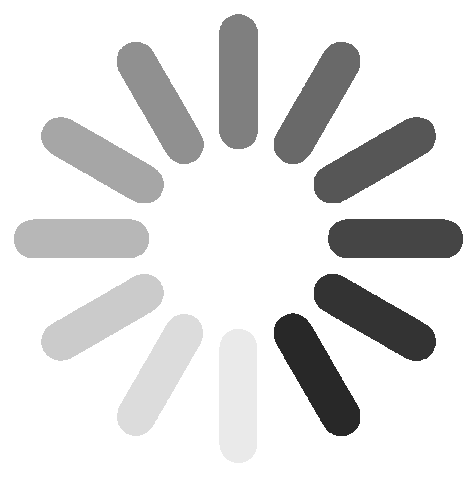

In [ ]:

main_plot = datamapplot.create_interactive_plot(
    l2_arr,
    l1_labels,
    l2_labels,

    hover_text=hover_labels,
    enable_search=True,
    background_color="#eeeeee",
    label_color_map= custom_color_map,
    marker_size_array=marker_size_array, 
    color_label_text=False,
    #darkmode=True
    
)

main_plot




## Web formatting

Now, we need to add so-called ['Front matter'](https://jekyllrb.com/docs/front-matter/) to the plot to ensure that the plot appears as as single page in our Github Pages. We'll use a function do this, where we define a number of variables that end up within the front matter, and therefore characteristics of the page.

In [ ]:

# Defined additional parameters for the front matter to give versatility in the site format
#def front_matter(figure,pagetitle,permalink,hidden,target_directory):
def front_matter(figure,pagetitle,target_directory): #Alt version excluding inexplicable quirks
    # Define the text to be added at the top of the HTML file
    header_text = f"""---
layout: page
title: {pagetitle}
---
"""
#permalink: /{permalink}/
#nav_exclude: {hidden}
#---
#"""

    # Ensure the target directory exists
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # Define the full file path
    file_path = os.path.join(target_directory, f"{pagetitle}.html")

    # Save the figure's HTML representation to a file within the target directory
    figure.save(file_path)

    # Read the saved HTML file
    with open(file_path, 'r') as f:
        figure_html = f.read()

    # Combine the header text with the figure's HTML
    full_html = header_text + figure_html

    # Save the combined HTML back to the file in the target directory
    with open(file_path, 'w') as f:
        f.write(full_html)

Test the front-matter addition function by calling it on the `main_plot` generated just above. The plot gives a visual overview of all so-called _functional requirements_.

In [ ]:
#Final variable ensures the current working directory (cwd) is used as the target dictory
#front_matter(main_plot, 'Functionality Overview', 'FunctionalRequirements','false',os.getcwd())

#v2 streamlined (c.f. front_matter function)
front_matter(main_plot, 'Functional Requirements',os.getcwd())

# Plot Personalization
## Preprocess 'StakeholderDiNo_FRs'

1. Creat standard elements names to match with elements in the 'entries_df'. 

2. Merge 'IT-01' to 'EF-03'

3. Encode the duplicated stakeholders ID (STK-011)

4. Fix #3

5. Rename

In [ ]:
print(Stakeholdercontributions.shape)
sc_remove = Stakeholdercontributions.loc[:, (Stakeholdercontributions.ne(0) & Stakeholdercontributions.notna()).any(axis=0)]
sc_cols =sc_remove.columns
print(sc_cols)
print(sc_remove.shape)

(90, 206)
Index(['Stakeholder ID', 'C-01 Preservation of evidence',
       'C-01-01 Audit Trail', 'C-01-02 Electronic signature',
       'C-01-03 Locking', 'C-01-04 Timestamping', 'C-01-05 Versioning',
       'C-01-06 None', 'C-02 Compliance certification',
       'C-02-04 FDA CFR 21 Part 11',
       ...
       'IT-04-01 Cloud of own choice', 'IT-04-02 Locally',
       'IT-04-03 Provider's Cloud', 'IT-04-04 None',
       'U-01 Customisable user interface', 'U-02 Languages', 'U-03 Support',
       'U-03-01 Vendor consultation', 'U-03-02 Online vendor documentation',
       'U-03-03 Vendor-supplied training'],
      dtype='object', length=142)
(90, 142)


In [ ]:


codes = []
names = []
for col in sc_cols[1:]:
    col_code = col.split(' ',1)[0]
    codes.append(col_code)
    col_name = col.split(' ',1)[1]
    if 'IT-01' in col_code:
        col_code = 'EF-03-'+ col_code
    if col_name == 'None':
      
        col_name = FR_Weights.at[col_code, 'Subject']
        names.append(col_name)
        
    else:
        names.append(col_name)
    sc_remove = sc_remove.rename(columns={col: col_name})

sc_remove.head()



,Stakeholder ID,Preservation of evidence,Audit Trail,Electronic signature,Locking,Timestamping,Versioning,Preservation of evidence - None,Compliance certification,FDA CFR 21 Part 11,...,Cloud of own choice,Locally,Provider's Cloud,Data storage location - None,Customisable user interface,Languages,Support,Vendor consultation,Online vendor documentation,Vendor-supplied training
0,Sheep,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Narwhal,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Nyan Cat,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Dolphin,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Dingo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Create extra dataframe to build 'marker_alpha_array' and 'marker_color_array'

## Full-colour plots

Full-colour versions of personalised plots, where opacity/transparency (`alpha`) is used to indicate where specific attributes are selected.

 __NOTE__ :bangbang: Use of transparency with DataMapPlot in interactive plot is not supported for versions 0.3.0 and below. At the time of writing v0.3.0 is the version available through `conda-forge`. The environment provided therefore loaded datamapplot _last_, via `pip`, to obtain the latest version (0.5.1), into a conda virtual environment

In [ ]:
sc_remove=sc_remove.set_index('Stakeholder ID')
sc_remove_cols = sc_remove.columns
sc_remove = sc_remove[l2_labels]


In [ ]:
print(sc_remove.index[0:5].to_list())
sc_remove_cols = sc_remove.columns
print(sc_remove_cols)

['Sheep', 'Narwhal', 'Nyan Cat', 'Dolphin', 'Dingo']
Index(['Audit Trail', 'Electronic signature', 'Locking', 'Timestamping',
       'Versioning', 'Preservation of evidence - None', 'FDA CFR 21 Part 11',
       'General Data Protection Regulation (GDPR)',
       'Good Clinical practice (GCP)', 'ISO 27001',
       ...
       'Command line interface (CLI)', 'Cloud of own choice', 'Locally',
       'Provider's Cloud', 'Data storage location - None',
       'Customisable user interface', 'Languages', 'Vendor consultation',
       'Online vendor documentation', 'Vendor-supplied training'],
      dtype='object', length=124)


## Dark version

In [ ]:
'''#custom_color_map = {label: color_map[i % len(color_map)] for i, label in enumerate(l2_labels)}
for idx, stakehoder_contri in sc_remove.iterrows():

    #custom_color_map_copy = custom_color_map.copy()
    marker_alpha_array = np.array([1 if value > 0 else 0.15 for value in stakehoder_contri ])


    plot_test = datamapplot.create_interactive_plot(
        l2_arr,
        l1_labels,
        l2_labels,
        hover_text=hover_labels,
        marker_alpha_array=marker_alpha_array,
        label_color_map= custom_color_map,
        color_label_text=False,
        darkmode=True
    )

    break 

plot_test.save(" plot_test.html")'''


'#custom_color_map = {label: color_map[i % len(color_map)] for i, label in enumerate(l2_labels)}\nfor idx, stakehoder_contri in sc_remove.iterrows():\n\n    #custom_color_map_copy = custom_color_map.copy()\n    marker_alpha_array = np.array([1 if value > 0 else 0.15 for value in stakehoder_contri ])\n\n\n    plot_test = datamapplot.create_interactive_plot(\n        l2_arr,\n        l1_labels,\n        l2_labels,\n        hover_text=hover_labels,\n        marker_alpha_array=marker_alpha_array,\n        label_color_map= custom_color_map,\n        color_label_text=False,\n        darkmode=True\n    )\n\n    break \n\nplot_test.save(" plot_test.html")'

In [ ]:

for idx, stakehoder_contri in sc_remove.iterrows():


    marker_alpha_array = np.array([1 if value > 0 else 0.15 for value in stakehoder_contri ])
                
  
    plot_grey = datamapplot.create_interactive_plot(
        l2_arr,
        l1_labels,
        l2_labels,
        hover_text=hover_labels,
        enable_search=True,
        #background_color="#eeeeee",
        label_color_map=custom_color_map,
        marker_alpha_array=marker_alpha_array,
        #marker_size_array=marker_size_array, 
        color_label_text=False,
        darkmode=True
        #width = 800, #Set width (in pixels) to match that used as the default page width
        #height = 800,
        )

    front_matter(plot_grey,idx,'_plots')
  
